# Natural Language Preprocessing (+ a little bit of EDA)

## Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

### Read in the data

In [27]:
df = pd.read_csv('data/raw_data.csv')
df.head()

,selftext,title,conspiracy,post_length,post_words,title_length,title_words
0,video is here: [https://youtu.be/tcuixijbfcy]...,Veteran's Advocate and 2A supporter Jon Stewar...,1,403,57,71,10
1,i've stumbled on a youtube channel i think is ...,I think I found a propaganda Youtube Channel,1,1349,235,44,8
2,"if you’re in the uk, you’ve probably seen the ...",Matt Hancock (UK senior politician turned show...,1,351,62,94,12
3,anyone else get a 7 day ban from responding to...,Banned - Deleted topic,1,249,44,22,4
4,the fda can 100% legally start genetically alt...,I learned the FDA is completely fine with comp...,1,124,21,161,27


In [28]:
X = df.drop(columns=['conspiracy'])
y = df['conspiracy']

## NLP Preprocessing

> After each step, we will define a function accomplishing the preprocessing step to be used in a pipeline later.

In [29]:
# Initialize text-based features
text_cols = df.select_dtypes('object').columns

### Tokenization

In [30]:
tokenizer = RegexpTokenizer(r'\w+')
X[text_cols] = X[text_cols].applymap(lambda x: ' '.join(tokenizer.tokenize(x.lower())))

In [31]:
X.head()

,selftext,title,post_length,post_words,title_length,title_words
0,video is here https youtu be tcuixijbfcy https...,veteran s advocate and 2a supporter jon stewar...,403,57,71,10
1,i ve stumbled on a youtube channel i think is ...,i think i found a propaganda youtube channel,1349,235,44,8
2,if you re in the uk you ve probably seen the m...,matt hancock uk senior politician turned showb...,351,62,94,12
3,anyone else get a 7 day ban from responding to...,banned deleted topic,249,44,22,4
4,the fda can 100 legally start genetically alte...,i learned the fda is completely fine with comp...,124,21,161,27


In [32]:
# Function form:
def tokenize(text, tokenizer=RegexpTokenizer(r'\w+')):
    return ' '.join(tokenizer.tokenize(text.lower()))

### Stop Word Removal

In [33]:
# This cell takes a while to run
X[text_cols] = X[text_cols].applymap(
                            lambda x: ' '.join(
                            [word for word in x.split() 
                            if word not in stopwords.words('english')]))
X.head()

,selftext,title,post_length,post_words,title_length,title_words
0,video https youtu tcuixijbfcy https youtu tcui...,veteran advocate 2a supporter jon stewart evis...,403,57,71,10
1,stumbled youtube channel think propaganda engi...,think found propaganda youtube channel,1349,235,44,8
2,uk probably seen matt hancock whatsapp release...,matt hancock uk senior politician turned showb...,351,62,94,12
3,anyone else get 7 day ban responding user they...,banned deleted topic,249,44,22,4
4,fda 100 legally start genetically altering pop...,learned fda completely fine companies putting ...,124,21,161,27


In [34]:
# Function form:
def remove_stopwords(text):
    return ' '.join([word for word in text.split()
                     if word not in stopwords.words('english')])

### Lemmatization

In [35]:
wn_lem = WordNetLemmatizer()
X[text_cols] = X[text_cols].applymap(
                            lambda x: ' '.join(
                            [wn_lem.lemmatize(word)for word in x.split()]))

In [36]:
X.head()

,selftext,title,post_length,post_words,title_length,title_words
0,video http youtu tcuixijbfcy http youtu tcuixi...,veteran advocate 2a supporter jon stewart evis...,403,57,71,10
1,stumbled youtube channel think propaganda engi...,think found propaganda youtube channel,1349,235,44,8
2,uk probably seen matt hancock whatsapp release...,matt hancock uk senior politician turned showb...,351,62,94,12
3,anyone else get 7 day ban responding user they...,banned deleted topic,249,44,22,4
4,fda 100 legally start genetically altering pop...,learned fda completely fine company putting na...,124,21,161,27


In [37]:
# Function form:
def lem(text, lem=WordNetLemmatizer()):
    return ' '.join([lem.lemmatize(word) for word in text.split()])

### Stemming

In [38]:
ps = PorterStemmer()
X[text_cols] = X[text_cols].applymap(
                            lambda x: ' '.join(
                            [ps.stem(word) for word in x.split()]))

In [39]:
X.head()

,selftext,title,post_length,post_words,title_length,title_words
0,video http youtu tcuixijbfci http youtu tcuixi...,veteran advoc 2a support jon stewart eviscer n...,403,57,71,10
1,stumbl youtub channel think propaganda engin u...,think found propaganda youtub channel,1349,235,44,8
2,uk probabl seen matt hancock whatsapp releas g...,matt hancock uk senior politician turn showbiz...,351,62,94,12
3,anyon els get 7 day ban respond user theyreall...,ban delet topic,249,44,22,4
4,fda 100 legal start genet alter popul even con...,learn fda complet fine compani put nanotechnol...,124,21,161,27


In [40]:
def stem(text, stemmer=PorterStemmer()):
    return ' '.join([stemmer.stem(word) for word in text.split()])

___

## Applying Count Vectorization

- We will apply Count Vectorization to both the title and selftext columns. After this, we will combine the two into one dataframe and join that to the rest of the X data.

In [41]:
X.shape

(12456, 6)

### Selftext Count Vectorization

We'll be focusing on trying to unearth some of the common attitudes and argumentative structures in each subreddits' sentence components. To do this, we'll analyze only the tri-grams and 4-grams that are used in the selftext column.

In [42]:
vec = CountVectorizer(stop_words='english',max_features=2000, ngram_range=(3,4))

In [43]:
X_selftext_cv = vec.fit_transform(X['selftext'])
st_vec_df = pd.DataFrame(X_selftext_cv.todense(), columns=vec.get_feature_names_out())
st_vec_df.head()

,000 year ago,06 01 pdf,09 26 gmt,09 26 gmt fda,090177e196ea1800 approv approv,090177e196ea1800 approv approv 30,10 15 year,10 year ago,100 amp format,100 piec evid,...,youtub com watch gyhii,youtub http www,youtub http www youtub,youtub video http,yr 11 month,zaporizhzhia nuclear plant,zaporizhzhia nuclear plant mar,аt thе sаmе,оf thе russiаn,оf thе russiаn fеdеrаtiоn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
st_vec_df.shape

(12456, 2000)

### A little EDA

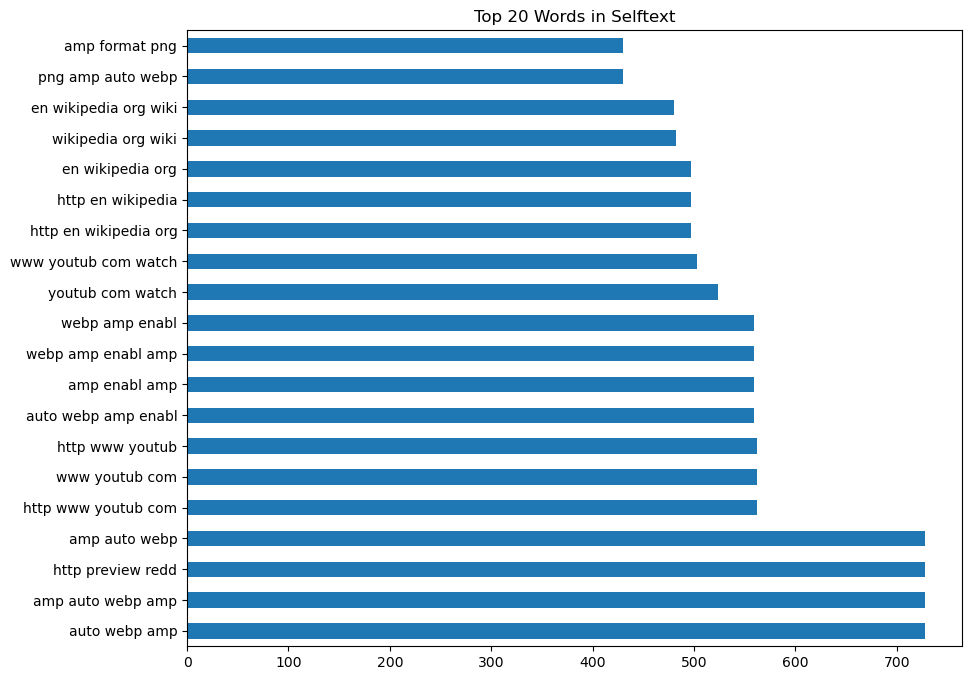

In [45]:
# Top 20 words in selftext
st_vec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 8))
plt.title('Top 20 Words in Selftext');

#### We see here some n-grams like **(www http youtube)** and **(www wikipedia org)** that indicate the presence of links in a lot of the text. These start to detract from the meaning of the text, so we'll remove them from our data.

> We'll add these to our list of stop words for the final pipeline.

In [46]:
# Redefining X without web stopwords
WEB_STOPWORDS = ['www', 'http', 'https', 'com', 'youtube', 'wikipedia',
                 'org', 'format', 'pjpg', 'png', 'webp', 'amp', 'x200b',
                 'wiki'] 

X.selftext = X.selftext.apply(lambda x: ' '.join(
                                [word for word in x.split()
                                 if word not in WEB_STOPWORDS]))

# Revectorizing
X_selftext_cv = vec.fit_transform(X['selftext'])
st_vec_df = pd.DataFrame(X_selftext_cv.todense(), columns=vec.get_feature_names_out())
st_vec_df.head()

,000 year ago,01 pdf fr,01 pdf fr 1984,06 01 pdf,06 01 pdf fr,09 26 gmt,09 26 gmt fda,090177e196ea1800 approv approv,090177e196ea1800 approv approv 30,10 15 year,...,youtub youtub watch,yr 11 month,yr month day,yuval noah harari,zaporizhzhia nuclear plant,zaporizhzhia nuclear plant mar,аs wеll аs,аt thе sаmе,оf thе russiаn,оf thе russiаn fеdеrаtiоn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


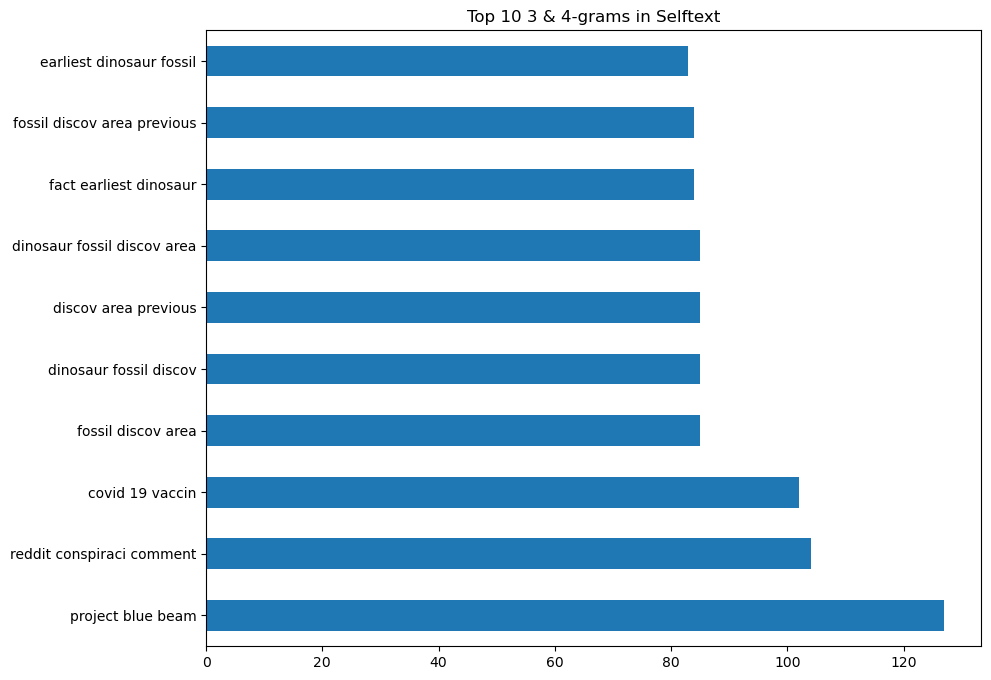

In [47]:
st_vec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 8))
plt.title('Top 10 3 & 4-grams in Selftext');

#### Now we have some interesting n-grams in here

> Aside: Redefining remove_stopwords function to include the new stop words

In [94]:
def remove_stopwords(text):
    WEB_STOPWORDS = ['www', 'http', 'https', 'com', 'youtube', 'wikipedia',
                    'org', 'format', 'pjpg', 'png', 'webp', 'amp', 'x200b',
                    'wiki','youtu', 'jpeg', 'jpg', 'gif', 'gifv', 'imgur',
                    'html'] 
    return ' '.join([word for word in text.lower().split()
                     if word not in
                     [*stopwords.words('english'), *WEB_STOPWORDS]])

___

### Title Count Vectorization

- For the titles, we won't worry about sentence structure or common phrases, just pure word frequency.

In [49]:
vec = CountVectorizer(stop_words='english',max_features=2000, ngram_range=(1,1))

In [50]:
X_title_cv = vec.fit_transform(X['title'])
title_vec_df = pd.DataFrame(X_title_cv.todense(), columns=vec.get_feature_names_out())
title_vec_df.head()

,000,02,10,100,11,119,12,13,14,15,...,year,yesterday,york,young,youtub,yr,zelenski,zero,zizek,zombi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


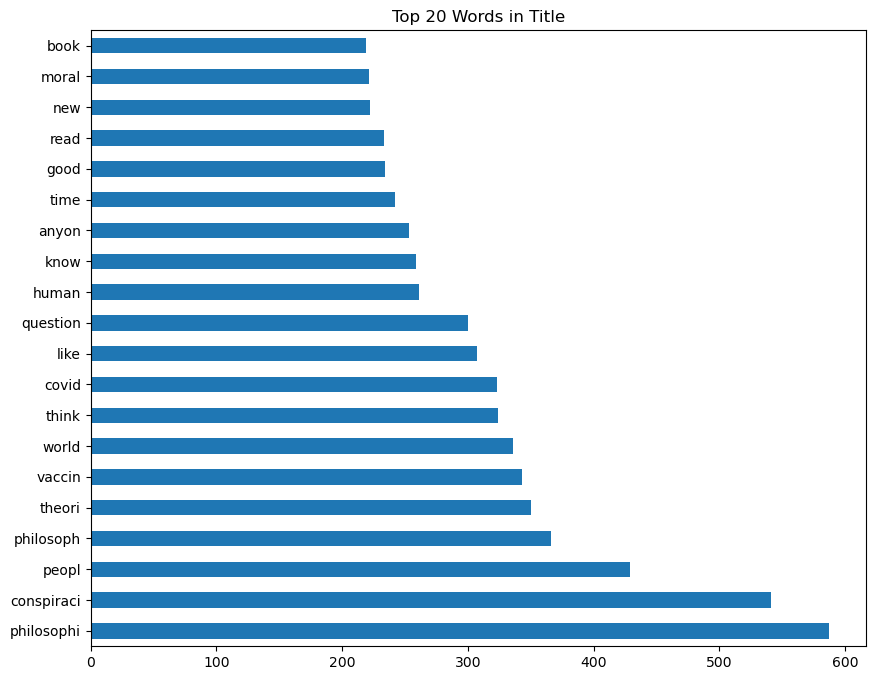

In [51]:
title_vec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 8))
plt.title('Top 20 Words in Title');

#### These look good, so no need to do anymore stopword removal. 

___

### Joining all of the data!

In [52]:
X = pd.concat([X, st_vec_df, title_vec_df], axis=1)
print(X.shape)
X.columns

(12456, 4006)


Index(['selftext', 'title', 'post_length', 'post_words', 'title_length',
       'title_words', '000 year ago', '01 pdf fr', '01 pdf fr 1984',
       '06 01 pdf',
       ...
       'year', 'yesterday', 'york', 'young', 'youtub', 'yr', 'zelenski',
       'zero', 'zizek', 'zombi'],
      dtype='object', length=4006)

___

## Sentiment Analysis

### Adding sentiment analysis scores

In [53]:
sa = SentimentIntensityAnalyzer()

In [54]:
def add_sentiment(df, col):
    sa = SentimentIntensityAnalyzer()
    df[col+'_neg'] = df[col].apply(lambda x: sa.polarity_scores(x)['neg'])
    df[col+'_neu'] = df[col].apply(lambda x: sa.polarity_scores(x)['neu'])
    df[col+'_pos'] = df[col].apply(lambda x: sa.polarity_scores(x)['pos'])
    df[col+'_compound'] = df[col].apply(lambda x: sa.polarity_scores(x)['compound'])
    return df

In [55]:
X = add_sentiment(X, 'selftext')
X = add_sentiment(X, 'title')
X.shape

(12456, 4014)

## Preprocessing Pipeline

In [122]:
# This function makes the resulting data more interesting for exploratory analysis, yet 
# (rather surprisingly) doesn't strongly impact the model's performance 
def remove_target_stems(text):
    return ' '.join([word for word in text.split()
                     if word not in
                     ['conspiraci', 'philosophi','philosoph']])

In [121]:
def preprocess(df):
    
    # Tokenize, remove stopwords, lemmatize, and stem
    text_cols = ['selftext', 'title']
    df[text_cols] = (df[text_cols]
                        .applymap(tokenize)
                        .applymap(remove_stopwords)
                        .applymap(lem)
                        .applymap(stem)
                        .applymap(remove_target_stems)  # 
                    )

    # Vectorize selftext for 3-4 grams
    stvec = CountVectorizer(stop_words='english',max_features=2000, ngram_range=(3,4))
    stvec_df = pd.DataFrame(
                    stvec.fit_transform(df['selftext']).todense(),
                    columns=stvec.get_feature_names_out()
                )
    
    # Vectorize title for 1-grams
    tivec = CountVectorizer(stop_words='english',max_features=2000, ngram_range=(1,1))
    tivec_df = pd.DataFrame(
                    tivec.fit_transform(df['title']).todense(),
                    columns=tivec.get_feature_names_out()
                )
    
    # Concatenate vectorized dataframes
    df = pd.concat([df, stvec_df, tivec_df], axis=1)
    
    # Add sentiment scores
    for col in text_cols:
        df = add_sentiment(df, col)
    
    return df

In [123]:
# Testing the pipeline:
copy = df.copy()

In [124]:
# This cell takes a long time (about 6-7 minutes) to run
processed = preprocess(copy)

In [106]:
processed.head()

,selftext,title,conspiracy,post_length,post_words,title_length,title_words,000 year ago,01 pdf fr,01 pdf fr 1984,...,zizek,zombi,selftext_neg,selftext_neu,selftext_pos,selftext_compound,title_neg,title_neu,title_pos,title_compound
0,video tcuixijbfci tcuixijbfci seen discuss yet...,veteran advoc 2a support jon stewart eviscer n...,1,403,57,71,10,0,0,0,...,0,0,0.234,0.626,0.139,-0.4767,0.000,0.748,0.252,0.4019
1,stumbl channel think propaganda engin u govern...,think found propaganda channel,1,1349,235,44,8,0,0,0,...,0,0,0.016,0.922,0.061,0.6808,0.400,0.600,0.000,-0.2500
2,uk probabl seen matt hancock whatsapp releas g...,matt hancock uk senior politician turn showbiz...,1,351,62,94,12,0,0,0,...,0,0,0.137,0.748,0.115,0.0772,0.000,1.000,0.000,0.0000
3,anyon els get 7 day ban respond user theyreall...,ban delet topic,1,249,44,22,4,0,0,0,...,0,0,0.321,0.679,0.000,-0.8860,0.643,0.357,0.000,-0.5574
4,fda 100 legal start genet alter popul even warn,learn fda complet fine compani put nanotechnol...,1,124,21,161,27,0,0,0,...,0,0,0.141,0.707,0.152,0.0258,0.000,0.878,0.122,0.2023


In [125]:
processed.to_csv('data/processed.csv', index=False)

___